# Dose/Response models



--- Model Ranking (Log-Log AIC) ---
                            Model  RSS_loglog  AIC_loglog
7     Strachan et al., 2005 (EXP)    7.577331    1.565756
1    Strachan et al., 2005 (mean)    7.220176    3.179502
4    Teunis et al., 2004 (childs)    7.472323    3.454115
5           Crockett et al., 1996    8.244375    4.240716
8        Nauta et al., 2002 (EXP)   11.579404    4.958292
3    Teunis et al., 2004 (adults)    9.141064    5.066682
2  Strachan et al., 2005 (median)   11.740064    7.068526
0             Cassin et al., 1998   12.341481    7.468196
6       Cassin et al., 1998 (EXP)   16.373641    7.729850


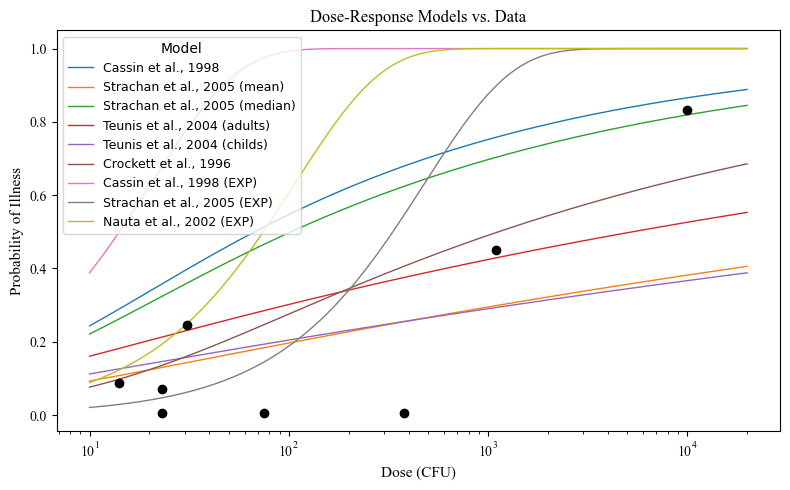

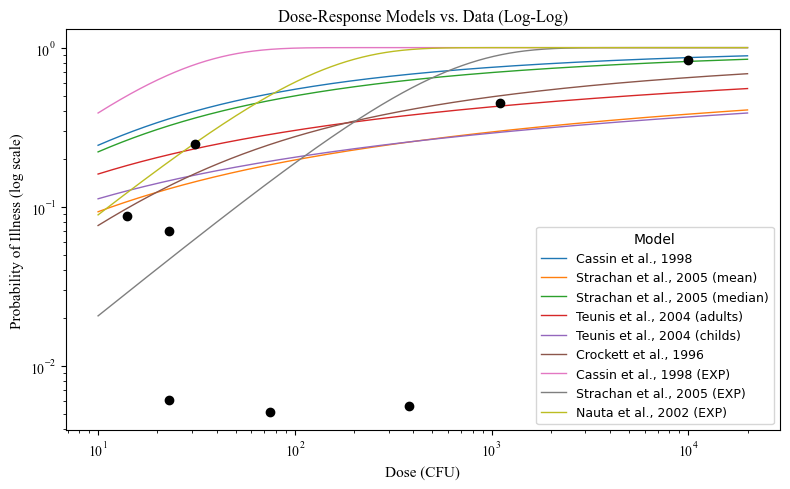

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Raw Data ---
dose = np.array([14, 31, 10000, 1100, 23, 23, 75, 380])
prob_illness = np.array([0.087719298, 0.24684271, 0.833333333, 0.450704225,
                         0.070642528, 0.00611951, 0.005106383, 0.005555556])
data = pd.DataFrame({'dose': dose, 'prob_illness': prob_illness})

# --- Models ---
def beta_poisson(dose, alpha, beta):
    return np.clip(1 - (1 + dose / beta) ** -alpha, 0, 1)

def exponential(dose, k):
    return np.clip(1 - np.exp(-k * dose), 0, 1)

models = {
    "Cassin et al., 1998": (beta_poisson, {"alpha": 0.267, "beta": 5.435}),
    "Strachan et al., 2005 (mean)": (beta_poisson, {"alpha": 0.05714, "beta": 2.2183}),
    "Strachan et al., 2005 (median)": (beta_poisson, {"alpha": 0.2241, "beta": 4.8807}),
    "Teunis et al., 2004 (adults)": (beta_poisson, {"alpha": 0.0844, "beta": 1.442}),
    "Teunis et al., 2004 (childs)": (beta_poisson, {"alpha": 0.0496, "beta": 1.001}),
    "Crockett et al., 1996": (beta_poisson, {"alpha": 0.162, "beta": 15.86}),
    "Cassin et al., 1998 (EXP)": (exponential, {"k": 0.049126035}),
    "Strachan et al., 2005 (EXP)": (exponential, {"k": 0.00208}),
    "Nauta et al., 2002 (EXP)": (exponential, {"k": 0.0093})
}

# --- Evaluation on log-log scale ---
eps = 1e-5
data['log_dose'] = np.log10(data['dose'])
data['log_prob'] = np.log10(np.clip(data['prob_illness'], eps, 1))

def evaluate_model_loglog(func, params, dose_obs, log_prob_obs):
    pred = func(dose_obs, **params)
    pred_log = np.log10(np.clip(pred, eps, 1))
    residuals = log_prob_obs - pred_log
    rss = np.sum(residuals ** 2)
    n = len(dose_obs)
    k = len(params)
    aic = n * np.log(rss / n) + 2 * k
    return rss, aic

results = []
for name, (func, params) in models.items():
    rss, aic = evaluate_model_loglog(func, params, data['dose'], data['log_prob'])
    results.append({"Model": name, "RSS_loglog": rss, "AIC_loglog": aic})

df_results = pd.DataFrame(results).sort_values("AIC_loglog")
print("\n--- Model Ranking (Log-Log AIC) ---")
print(df_results)

# --- Predictions ---
dose_seq = np.logspace(np.log10(10), np.log10(20000), 500)
predictions = []
for name, (func, params) in models.items():
    prob_pred = func(dose_seq, **params)
    predictions.append(pd.DataFrame({
        "dose": dose_seq,
        "prob_illness": prob_pred,
        "Model": name
    }))
df_long = pd.concat(predictions, ignore_index=True)

# --- Plot: Linear y-axis ---
plt.figure(figsize=(8, 5))
for model in df_long['Model'].unique():
    subset = df_long[df_long['Model'] == model]
    plt.plot(subset['dose'], subset['prob_illness'], label=model, linewidth=1)
plt.scatter(data['dose'], data['prob_illness'], color='black', zorder=5)
plt.xscale('log')
plt.xlabel("Dose (CFU)", fontsize=11, family="Times New Roman")
plt.ylabel("Probability of Illness", fontsize=11, family="Times New Roman")
plt.title("Dose-Response Models vs. Data", fontsize=12, family="Times New Roman")
plt.xticks(fontsize=10, family="Times New Roman")
plt.yticks(fontsize=10, family="Times New Roman")
plt.legend(title="Model", fontsize=9, title_fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Plot: Log-Log scale ---
plt.figure(figsize=(8, 5))
for model in df_long['Model'].unique():
    subset = df_long[df_long['Model'] == model]
    plt.plot(subset['dose'], subset['prob_illness'], label=model, linewidth=1)
plt.scatter(data['dose'], data['prob_illness'], color='black', zorder=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Dose (CFU)", fontsize=11, family="Times New Roman")
plt.ylabel("Probability of Illness (log scale)", fontsize=11, family="Times New Roman")
plt.title("Dose-Response Models vs. Data (Log-Log)", fontsize=12, family="Times New Roman")
plt.xticks(fontsize=10, family="Times New Roman")
plt.yticks(fontsize=10, family="Times New Roman")
plt.legend(title="Model", fontsize=9, title_fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()